In [1]:
import os
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import json
import numpy as np
from decouple import config

from functions import *

In [2]:
POSTGRES_USER = config('POSTGRES_USER')
POSTGRES_KEY = config('POSTGRES_KEY')

In [3]:
conn = psycopg2.connect(
   database="nepal", user=POSTGRES_USER, password=POSTGRES_KEY
)

In [4]:
sql = 'SELECT * FROM admin.npl_admbnda_adm0_nd_20201117'
df_adm0 = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM admin.npl_admbnda_adm1_nd_20201117'
df_adm1 = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM admin.npl_admbnda_adm2_nd_20201117'
df_adm2 = gpd.read_postgis(sql, conn)
df_adm1['id'] = df_adm1.index
sql = 'SELECT * FROM admin.npl_admbnda_districts_nd_20201117'
df_dist = gpd.read_postgis(sql, conn)

<AxesSubplot:>

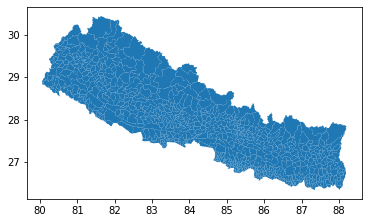

In [5]:
df_adm2.plot()

In [6]:
sql = 'SELECT * FROM power_network.substations_georeferenced'
df_sub = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM power_network.hv_lines_georeferenced'
df_hv = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM power_network.micro_hydropower'
df_mh = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM power_network.distribution_coverage'
df_dist = gpd.read_postgis(sql, conn)

<AxesSubplot:>

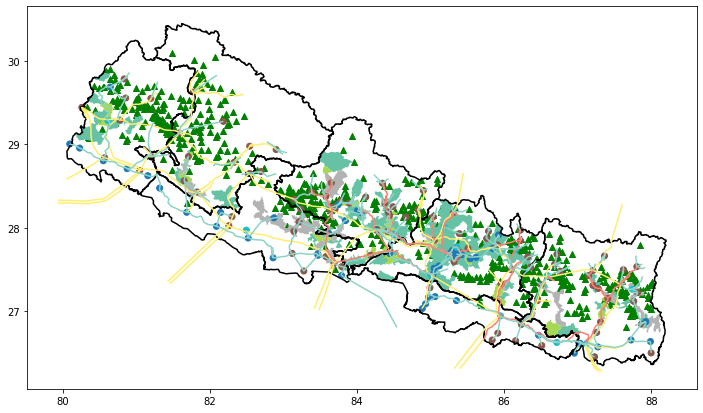

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
df_adm1.boundary.plot(color='black', ax=ax)
df_hv.plot(column='voltage', cmap='Set3', ax=ax)
df_mh.plot(marker="^", color='green', ax=ax)
df_dist.plot(column='voltage', cmap='Set2', ax=ax)
df_sub.plot(column='status', ax=ax)

## MCA analysis

### Calculating proximity to education facilities

In [20]:
sql = 'SELECT * FROM places.education_facilities'
df_edu = gpd.read_postgis(sql, conn)

rasterize(df_edu.to_crs(3395), 'data/population_npl_2018-10-01_1km.tif', 'temp/rasterized_edu.tif', 
          compression='DEFLATE')
proximity_raster('temp/rasterized_edu.tif', 'temp/output_edu.tif', [1], 'DEFLATE')
mask_raster('temp/output_edu.tif', df_adm0.to_crs(3395), 
            'temp/output_masked_edu.tif', -9999, 'DEFLATE')

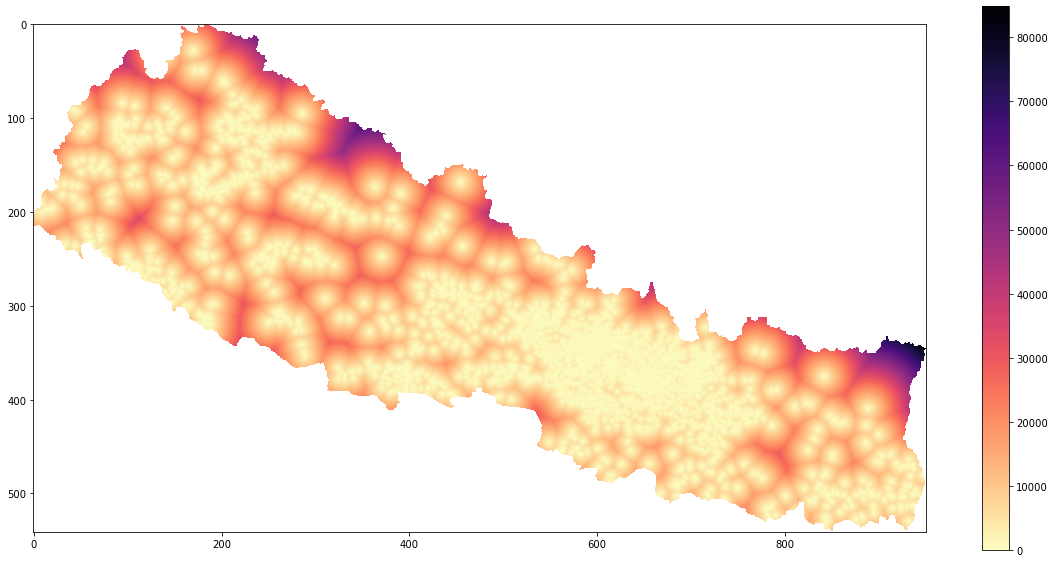

In [14]:
with rasterio.open('temp/output_masked_edu.tif') as src:
    raster = src.read(1)
    raster[raster<0] = np.nan
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(raster, cmap='magma_r')
plt.colorbar(shrink=0.5)

### Loading population density data

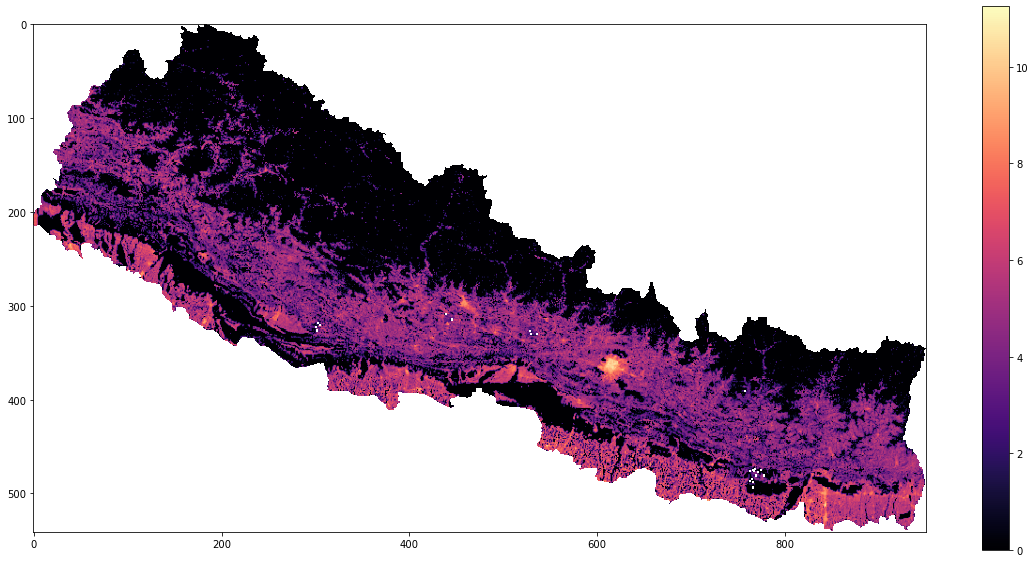

In [16]:
with rasterio.open('data/population_npl_2018-10-01_1km.tif') as src:
    raster = src.read(1)
    raster[raster==0] = np.nan
    raster[raster>0] = np.log(raster[raster>0])
    raster = np.nan_to_num(raster, nan=0)
    raster[raster<0] = np.nan
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(raster, cmap='magma')
plt.colorbar(shrink=0.5)

### Calculating demand index

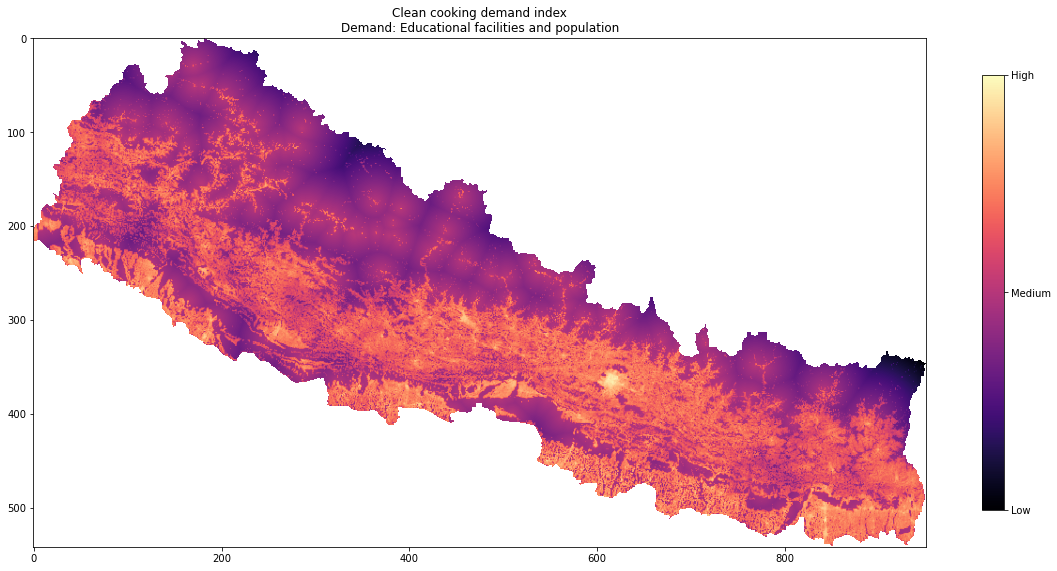

In [50]:
with rasterio.open('data/population_npl_2018-10-01_1km.tif') as src:
    population = src.read(1)
    population[population==0] = np.nan
    population[population>0] = np.log(population[population>0])
    population = np.nan_to_num(population, nan=0)
    population[population<0] = np.nan

    population = population / (np.nanmax(population) - np.nanmin(population))
    population = np.nan_to_num(population, nan=0)

rasters = [1 - normalize('temp/output_masked_edu.tif'),
           population]
weights = [1, 1]

demand_index = index(rasters, weights)
    
fig, ax = plt.subplots(1, 1)
cax = ax.imshow(demand_index, cmap='magma', vmin=0, vmax=1)
cbar = fig.colorbar(cax, shrink=0.8, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
plt.title('Clean cooking demand index\nDemand: Educational facilities and population')
fig.set_size_inches(20, 10)

### Calculating proximity to existing transmision substations

In [8]:
rasterize(df_sub.to_crs(3395).loc[df_sub['status']=='E'], 'data/population_npl_2018-10-01_1km.tif', 
          'temp/rasterized_sub.tif', compression='DEFLATE')
proximity_raster('temp/rasterized_sub.tif', 'temp/output_sub.tif', [1], 'DEFLATE')
mask_raster('temp/output_sub.tif', df_adm0.to_crs(3395), 
            'temp/output_masked_sub.tif', -9999, 'DEFLATE')

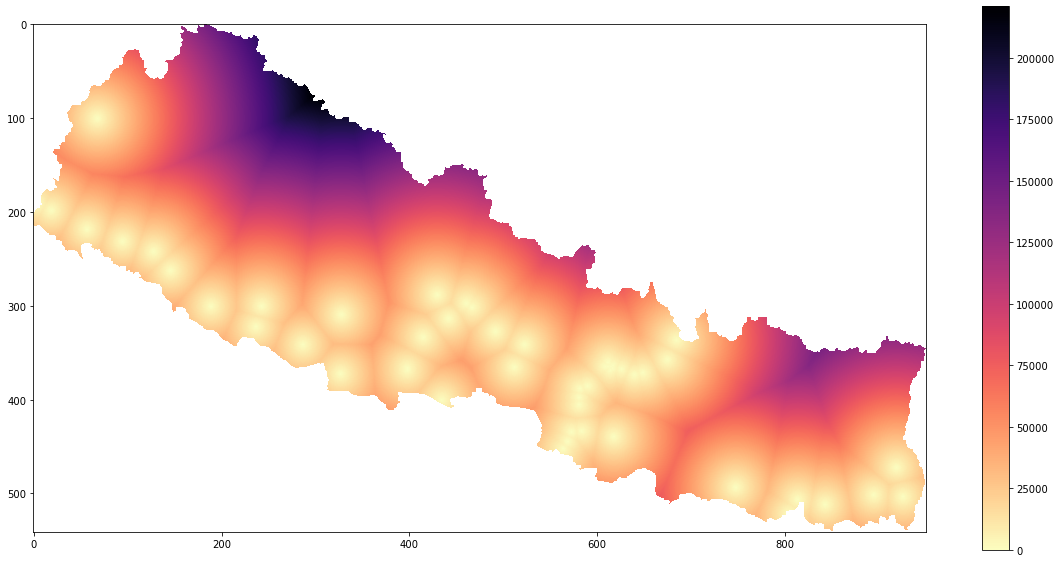

In [9]:
with rasterio.open('temp/output_masked_sub.tif') as src:
    raster = src.read(1)
    raster[raster<0] = np.nan
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(raster, cmap='magma_r')
plt.colorbar(shrink=0.5)

### Calculating proximity to HV lines

In [10]:
df_hv_buffer = df_hv.copy().to_crs(3395)
df_hv_buffer['geom'] = df_hv_buffer['geom'].buffer(1)

rasterize(df_hv_buffer.loc[df_hv_buffer['status']=='E'], 'data/population_npl_2018-10-01_1km.tif', 'temp/rasterized_hv.tif', 
          value='voltage', compression='DEFLATE', dtype='uint16', all_touched=True)
proximity_raster('temp/rasterized_hv.tif', 'temp/output_hv.tif', [132, 220, 400], 'DEFLATE')
mask_raster('temp/output_hv.tif', df_adm0.to_crs(3395), 
            'temp/output_masked_hv.tif', -9999, 'DEFLATE')

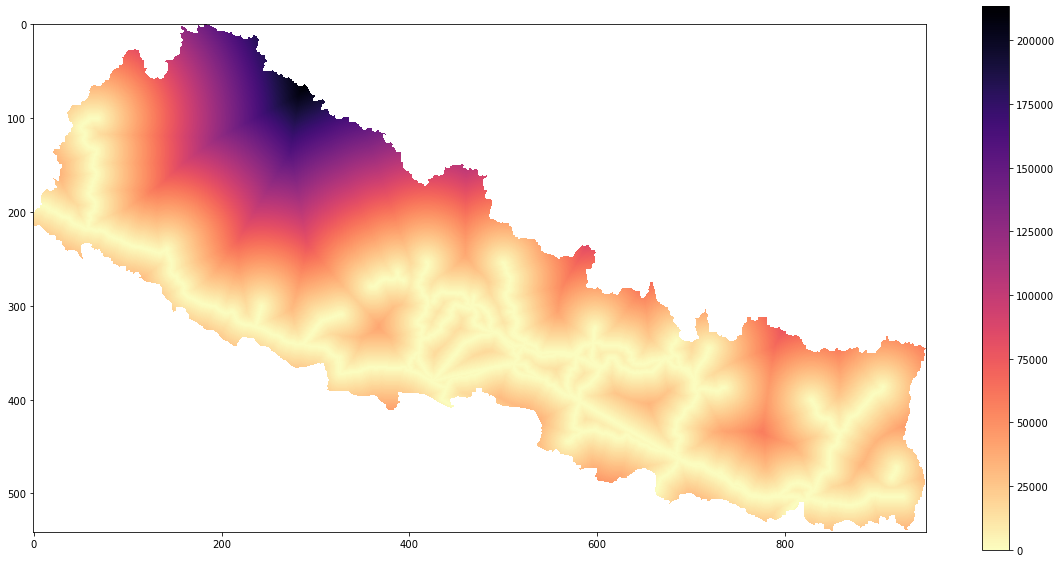

In [11]:
with rasterio.open('temp/output_masked_hv.tif') as src:
    raster = src.read(1)
    raster[raster<0] = np.nan
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(raster, cmap='magma_r')
plt.colorbar(shrink=0.5)

### Calculating supply index

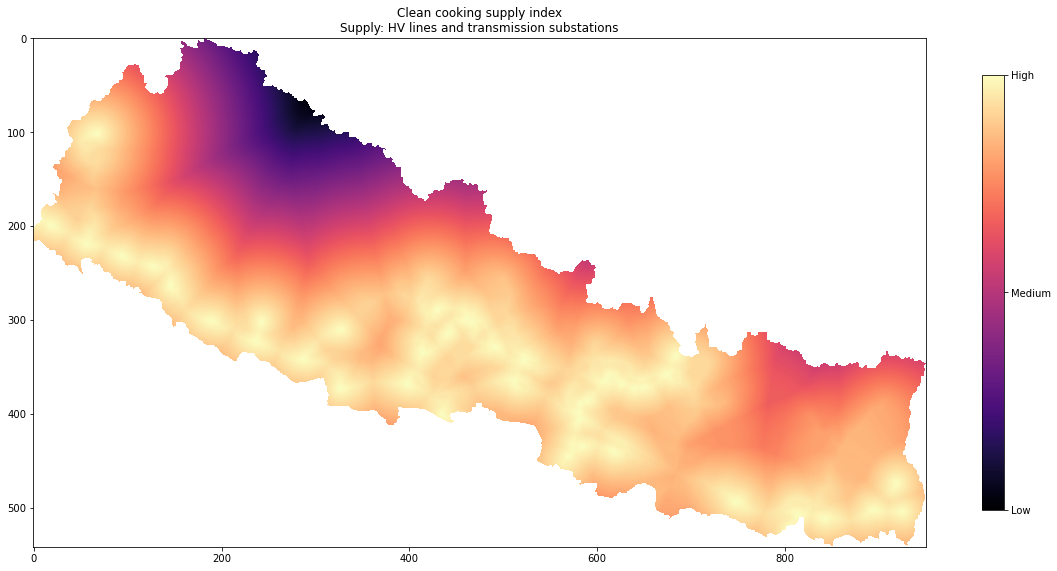

In [51]:
rasters = [1 - normalize('temp/output_masked_sub.tif'), 
           1 - normalize('temp/output_masked_hv.tif')]
weights = [1, 1]

supply_index = index(rasters, weights)
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
cax = ax.imshow(supply_index, cmap='magma', vmin=0, vmax=1)
cbar = fig.colorbar(cax, shrink=0.8, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
plt.title('Clean cooking supply index\nSupply: HV lines and transmission substations')
fig.set_size_inches(20, 10)

### Calculating the Clean Cooking Potential index

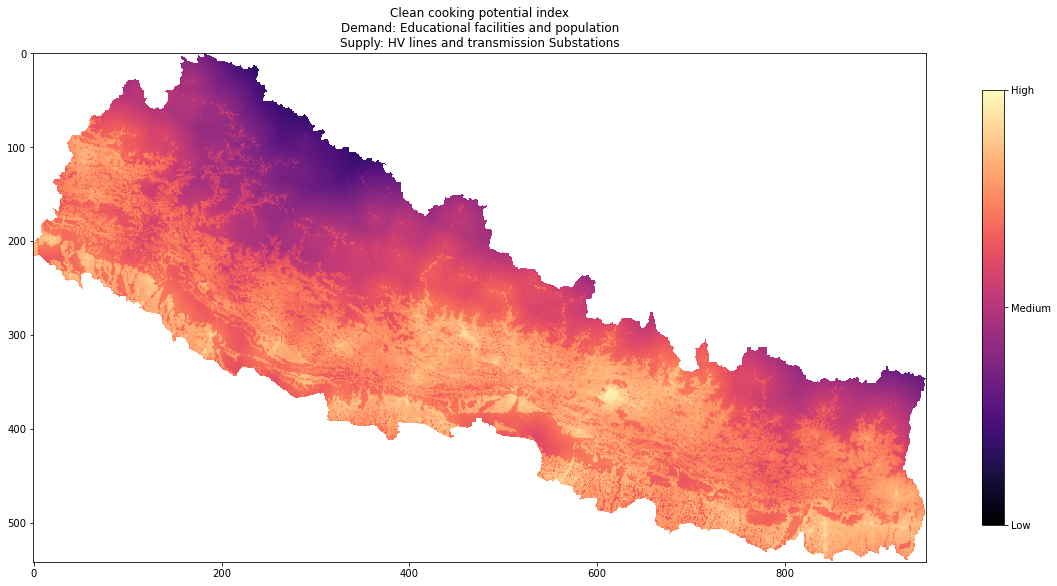

In [52]:
with rasterio.open('data/population_npl_2018-10-01_1km.tif') as src:
    population = src.read(1)
    population[population==0] = np.nan
    population[population>0] = np.log(population[population>0])
    population = np.nan_to_num(population, nan=0)
    population[population<0] = np.nan

    population = population / (np.nanmax(population) - np.nanmin(population))
    population = np.nan_to_num(population, nan=0)

rasters = [1 - normalize('temp/output_masked_edu.tif'),
           population]
weights = [1, 1]

demand_index = index(rasters, weights)
w_s = 1
w_d = 1
ccp_index = (w_s * supply_index + w_d * demand_index) / (w_s + w_d)
    
fig, ax = plt.subplots(1, 1)
cax = ax.imshow(ccp_index, cmap='magma', vmin=0, vmax=1)
cbar = fig.colorbar(cax, shrink=0.8, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
plt.title('Clean cooking potential index\nDemand: Educational facilities and population\nSupply: HV lines and transmission Substations')
fig.set_size_inches(20, 10)
# fig.savefig("clean_cooking_potential.png", dpi=300)

In [21]:
sql = 'SELECT * FROM cooking_fuels.wood'
df_wood = gpd.read_postgis(sql, conn)

<AxesSubplot:>

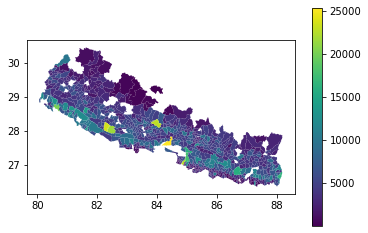

In [28]:
df_wood.plot(column='Wood / Firewood', legend=True)

Text(0.5, 1.0, 'Percentage of households cooking with firewood per municipality')

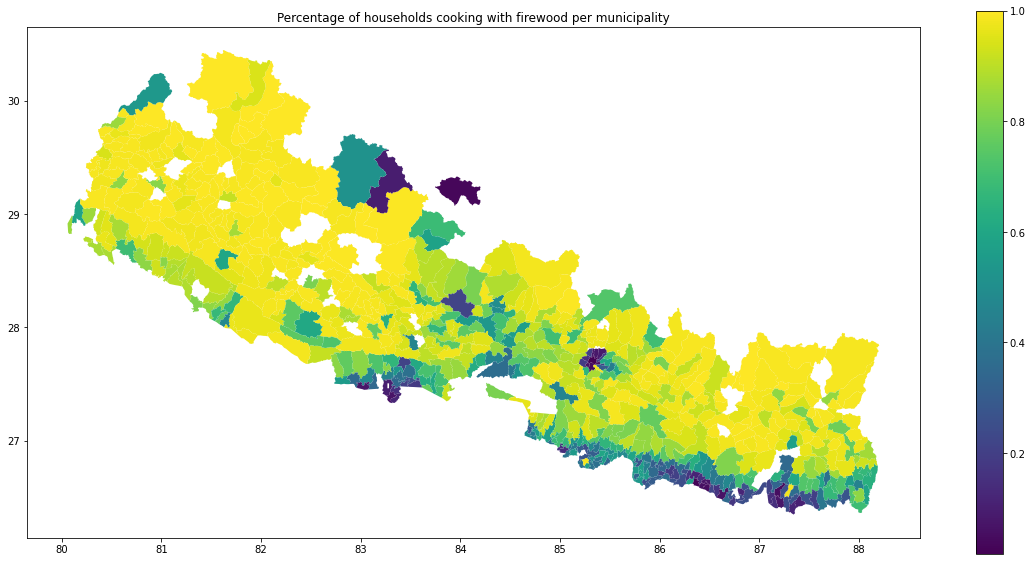

In [57]:
df_wood['percentage'] = df_wood['Wood / Firewood'] / df_wood['Total households']
df_wood.plot(column='percentage', legend=True, figsize=(20, 10))
plt.title('Percentage of households cooking with firewood per municipality')

In [45]:
df_wood_filtered = df_wood.loc[df_wood['percentage']>=0.8].to_crs(3395)
mask_raster('maps/ccp_index.tif', df_wood_filtered, 
            'maps/ccp_index_filtered.tif', np.nan, 'DEFLATE')

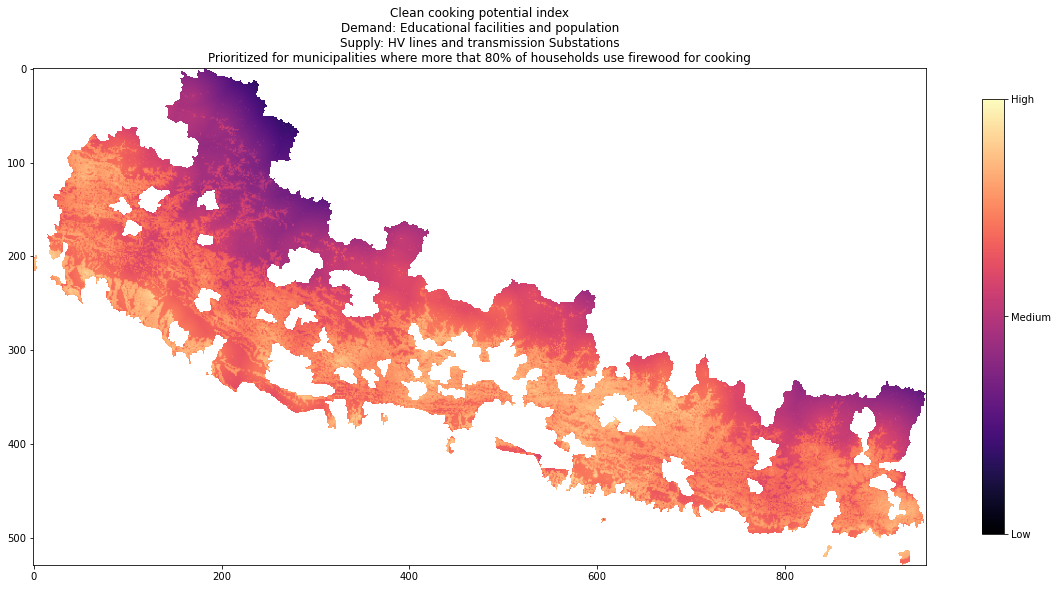

In [59]:
with rasterio.open('maps/ccp_index_filtered.tif') as src:
    raster = src.read(1)

fig, ax = plt.subplots(1, 1)
cax = ax.imshow(raster, cmap='magma', vmin=0, vmax=1)
cbar = fig.colorbar(cax, shrink=0.8, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
plt.title('Clean cooking potential index\nDemand: Educational facilities and population\nSupply: HV lines and transmission Substations\nPrioritized for municipalities where more that 80% of households use firewood for cooking')
fig.set_size_inches(20, 10)

### Saving results

In [18]:
with rasterio.open('data/population_npl_2018-10-01_1km.tif') as src:
    out_meta = src.meta

with rasterio.open('maps/ccp_index.tif', "w", **out_meta) as dest:
    dest.write(ccp_index, indexes=1)